# Constructing the likelihood of cosmological parameters using MCMC chain:
# Metropolis-Hastings vs. Affine-Invariance


In this notebook, I show how MCMC chains work to evaluate the likelihood of cosmological parameters

The cosmic microwave background (CMB) is electromagnetic radiation as a remnant from an early stage of the universe in the standard cosmology. The use of CMB observation enables us to explore the evolution of the Universe and temperatures at all angular positions are measured for this study. There are 6 parameters which descibe the evolution of the cosmic structure and the paramters with relavant physical models constraint the angular distribution of temperature. The cosmological parameters are:
> - **Ω_b**: density of baryonic matter
- **Ω_cdm**: density of cold dark matter (cdm)
- **τ_reio**: optical depth at the epoch of reionization
- **θ_s**: the angular scale of the sound horizon at matter-radiation equality
- **A_s**: curvature perturbations
- **n_s**: scalar spectral index.



The finite-dimensional distribution (hearafter f.d.d. data is discretely spaced in the units of pixel) of cosmic temperature follow a Gaussian random process. The observed data consist of: 
\begin{aligned}
\vec{\rm d}~({\rm =}~ d(\hat{n})) = T(\hat{n}) + \mathcal{E}(\hat{n}) 
\end{aligned}
where $\vec{\rm d}$(or d($\hat{n}$)) is data , T($\hat{n}$) $\sim (0,\Sigma^{TT}(\vec{p}))$ is model temperature, $\mathcal{E}$($\hat{n}$) $\sim (0,\Sigma^{\mathcal{EE}})$ is noise bias, and $\hat{n}$ is angular position vector. 

Acutally, the temperature we observe is PSF-convolved one. Therefore, <br>
\begin{aligned}
&~d(\hat{n}) = \phi * T(\hat{n}) + \mathcal{E}(\hat{n}) ~ :{\rm general~expression}\\
\Longleftrightarrow &~d_{lm} = (\phi * T)_{lm} + \mathcal{E}_{lm} ~~~ :{\rm expressed~in~spherical~harmonics~on~S}^2
\end{aligned}              
where $\phi$ is a Gaussian beam PSF on $S^2$.

Dividing by the beam and renaming $d_{lm}~\&~\mathcal{E}_{lm}$ gives a general model for observation:
\begin{aligned}
d_{lm} = T_{lm} + \mathcal{E}_{lm} ~~~ {\rm for~}l={\rm 0,1,2,\cdots,~and~}m=-l,-l+1,\cdots,l-1,l
\end{aligned}     
where $E(T_{lm}\cdot\overline{T_{l'm'}})=\delta_{ll'}\delta_{mm'}C_l^{TT}$,
$E(\mathcal{E}_{lm}\cdot\overline{\mathcal{E}_{l'm'}})=\delta_{ll'}\delta_{mm'}C_l^{\mathcal{EE}}
= \delta_{ll'}\delta_{mm'}\sigma^2\exp\bigg(\frac{b^2}{8\ln 2}l(l+1)\bigg)$, $\sigma$ is addictive noise level, and $b$ is FWHM of the PSF.



# Getting Started: reading data & initializing paramters

As the first step of our analysis, I read a set of 9-year WMAP data with estimated cosmological paramters and fully available  MCMC chain (Hinshaw et al. 2013). The mean of each parameter data is the best estimate by WMAP observation.

In [25]:
from matplotlib import pyplot as plt
import getdist
import getdist.plots as plots
import seaborn as sns
import numpy as np
import h5py
import sys
import warnings
import pypico
import nlopt
warnings.filterwarnings('ignore')

def cov(mat):
    # kernel is dead when using np.cov()
    _, ncov = np.shape(mat)
    covmat = np.zeros((ncov,ncov),dtype=np.float64)
    for i in range(ncov):
        for j in range(i,ncov):
            if i==j:
                covmat[i,j] = np.var(mat[:,i])
            else:
                covmat[i,j] = np.cov(mat[:,i],mat[:,j])[0,1]
                covmat[j,i] = np.cov(mat[:,i],mat[:,j])[1,0]
    return covmat

path = './'

In [2]:
nlines = sum(1 for line in open(path+'omegach2'))
nchain = 100_000

Ω_b_chain      = np.loadtxt(path + 'omegabh2', usecols=(1),dtype = np.float64)[:nchain]
Ω_cdm_chain    = np.loadtxt(path + 'omegach2', usecols=(1),dtype = np.float64)[:nchain]
τ_reio_chain    = np.loadtxt(path + 'tau', usecols=(1),dtype = np.float64)[:nchain]
Θ_s_chain      = np.loadtxt(path + 'thetastar', usecols=(1),dtype = np.float64)[:nchain]
A_s_109_chain  = np.loadtxt(path + 'a002', usecols=(1),dtype = np.float64)[:nchain] # which is 10⁹ * A_s
n_s_chain      = np.loadtxt(path + 'ns002', usecols=(1),dtype = np.float64)[:nchain]


In [3]:
full_chain  = np.stack((Ω_b_chain, Ω_cdm_chain, 
                        τ_reio_chain, Θ_s_chain, 
                        A_s_109_chain, n_s_chain), axis = 1)

wmap_chain   = full_chain.copy()
names_chain  = ['Ω_b', 'Ω_cdm', 'τ_reio', 'Θ_s', '10^9 A_s', 'n_s']


σ2           = (10.0 / 3437.75)**2  # <---10μk arcmin noise level converted to radian pixels (1 radian = 3437.75 arcmin)
b2           = 0.0035**2          # <-- FWHM of 0.2ᵒ ≈ 12.0 armin ≈ 0.0035 radians      
π            = np.pi

Σwmap        = cov(full_chain)
invΣwmap     = np.linalg.inv(Σwmap)
detΣwmap     = np.linalg.det(Σwmap)
bandpowers   = (h5py.File(path + 'bandpowers.h5', 'r'))['bandpowers'].value # bandpower = sig_l

picoload     = pypico.load_pico(path+'pico3_tailmonty_v34_py3.dat')

wmap_best_fit = np.mean(full_chain, axis=0)

f = h5py.File(path + 'lcdm_sim_truth.h5', 'r')
lcdm_sim_truth = [i[0] for i in f['lcdm_sim_truth'].value]

In [4]:
print('best-fit value by wmap observation')
for name, val in zip(names_chain, wmap_best_fit):
    print('{:10s}: {:4.3f}'.format(name, val))


best-fit value by wmap observation
Ω_b       : 0.023
Ω_cdm     : 0.114
τ_reio    : 0.089
Θ_s       : 0.010
10^9 A_s  : 2.412
n_s       : 0.972


# Define "pico" function to calculate $C_l^{TT}$

"pico" function calculates the CMB power spectrum as a function of bandwidth (moments) based on a set of cosmological parameters.

In [5]:
def pico(x):
    Ω_b     = x[0]
    Ω_cdm   = x[1]
    τ_reio    = x[2]
    Θ_s     = x[3]
    A_s_109     = x[4]
    n_s         = x[5]    
    
    dict_input = {'scalar_amp(1)'          : 1e-9 * A_s_109,
                 're_optical_depth'        : τ_reio,
                 'theta'                   : Θ_s,
                 'ombh2'                   : Ω_b,
                 'omch2'                   : Ω_cdm,
                 'scalar_spectral_index(1)': n_s,
                 'massive_neutrinos'       : 3.04,
                 'helium_fraction'         : 0.25, 
                 'omnuh2'                  : 0, 
                 'scalar_nrun(1)'          : 0,
                  'force'                  : True
                 }    
    # The output of picoload is a dictionary with a bunch of spectral densities, i.e., clTT. 
    # However, here we only return clTT value.
    
    plout = picoload.get(**dict_input)
    clTT = plout['cl_TT'].astype(np.float64)
    ells = np.arange(len(clTT))   # multipole moment
    clTT *= 2 * π / ells / (ells + 1)    
    # Note: the CMB spectral densities already have a factor ell(ell+1)/(2pi).
    clTT[0] = 0.  # clTT[0] was infty
    return clTT


# Define Log likelihood of posterior and proposal. 
Since my choice of proposal is symmetric, I will ignore it. 

In [6]:
def LogPost(x):
    ClTT = pico(x)
    ell  = np.arange(len(ClTT))
    Cldd = ClTT + σ2 * np.exp(b2 * ell * (ell+1) / (8 * np.log(2)))
    rtn  = 0.0
    
    for l in ell[1:]: # change 2 -> 3,  l=1 "dipole"
        rtn -= np.log(Cldd[l]) * (2.*l+1) / 2
        rtn -= (bandpowers[l] / Cldd[l]) * (2.*l+1) / 2
    return rtn

def Porposal(θ1, θ2):
    d = len(θ1)
    xT = np.transpose(θ1 - θ2)
    x  = θ1 - θ2
    χ2 = np.matmul(np.matmul(xT, invΣwmap),x)    
    return np.exp(-0.5 * χ2 / np.sqrt( (2*π)**d * detΣwmap) )

    

In [7]:
picoload = pypico.load_pico(path+'pico3_tailmonty_v34_py3.dat')
# picoload.inputs()

In [8]:
def llmin(x, grad):
    return LogPost(x)

In [9]:
algm = ['LN_BOBYQA', 'LN_COBYLA', 'LN_PRAXIS', 'LN_NELDERMEAD', 'LN_SBPLX']
opt = nlopt.opt(nlopt.LN_BOBYQA, 6)
opt.set_upper_bounds([0.034, 0.2,  0.55,  .0108, np.exp(4.0)/10,  1.25])
opt.set_lower_bounds([0.018, 0.06, 0.01,  .0102, np.exp(2.75)/10, 0.85])
opt.set_maxtime(60.0) # in seconds
opt.set_max_objective(llmin)

In [10]:
optx = opt.optimize(wmap_best_fit)

Compare log likehoods with different sets of cosmological parameters

In [11]:
print(LogPost(optx) - LogPost(wmap_best_fit))
print(LogPost(optx) - LogPost(lcdm_sim_truth))

73.38060128688812
3.164376974105835


In [12]:
print('parameter values compared:')
print('{:10s}  {:4s}  {:4s}  {:4s}'.format('name\method','mle', 'wmap', 'sim'))
for i in range(len(names_chain)):
    print('{:10s}:  {:4.3f} {:4.3f} {:4.3f}'.format(
        names_chain[i], optx[i], wmap_best_fit[i], lcdm_sim_truth[i]))

parameter values compared:
name\method  mle   wmap  sim 
Ω_b       :  0.022 0.023 0.022
Ω_cdm     :  0.118 0.114 0.117
τ_reio    :  0.129 0.089 0.091
Θ_s       :  0.010 0.010 0.010
10^9 A_s  :  2.776 2.412 2.572
n_s       :  0.956 0.972 0.956


# Plotting CMB power spectrum (theoretical band power) using WMAP data

see also to compare plots: https://en.wikipedia.org/wiki/Cosmic_microwave_background#/media/File:PowerSpectrumExt.svg

Power spectrum, a.k.a. CMB anisotropy, is a measure of how the cosmic structure has evolved as a function of (angular) scale up to now. By measuring the temperture fluctuation of the Universe varying angular scale, we can construct the power spectrum. The shape depends on how the Universe evloves, which is well represented by cosmological parameters mentioned above.

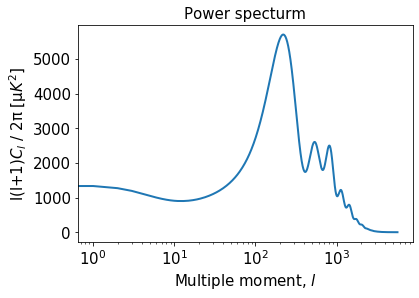

In [13]:
ells    = np.arange(len(bandpowers)) # array of 0 - 5625 = multiple moments.
rawClTT = pico(optx)
plt.semilogx(ells, ells *(ells+1) * rawClTT / (2*π), linewidth = 2)

plt.title("Power specturm", fontsize=15)
plt.xlabel("Multiple moment, $l$", fontsize=15)
plt.ylabel("l(l+1)$C_l$ / 2π [μ$K^2$]", fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

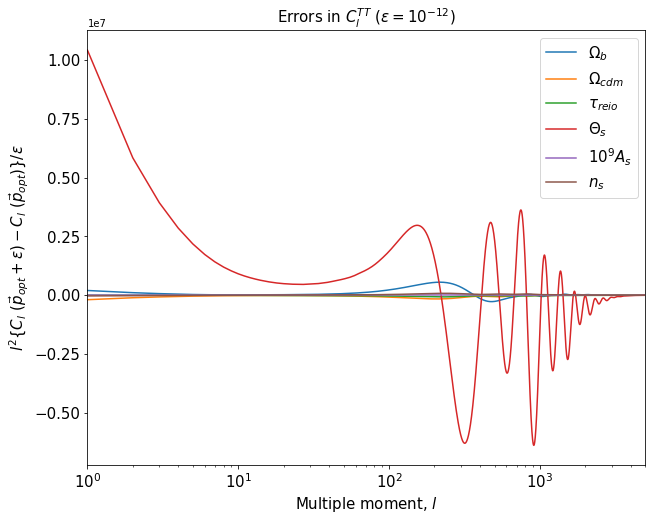

In [14]:
params = [ r'$\Omega_b$', r'$\Omega_{cdm}$', r'$\tau_{reio}$',r'$\Theta_s$',r'${10^9 A_s}$',r'$n_s$']

dϵ = 1e-12
v  = np.zeros(6)
v[0] = 1
X = np.zeros((len(bandpowers),6))
plt.figure(figsize=(10,8))
for i in range(6):
    X[:,i]   = (pico(optx + dϵ * np.roll(v,i)) - pico(optx))/dϵ
    param    = params[i]
    plt.semilogx(np.arange(len(bandpowers)), 
                (np.arange(len(bandpowers))+1.)**2 * X[:,i], label = params[i])

plt.legend(loc=1,fontsize=15)
plt.title('Errors in ' + '$C_l^{TT}$ ' + '($\epsilon = 10^{-12}$)' , fontsize = 15)
plt.xlabel('Multiple moment, ' + r'$l$', fontsize = 15)
plt.ylabel(r'$l^2 \{C_l\ (\vec{p}_{opt}+\epsilon) - C_l\ (\vec{p}_{opt})\}/\epsilon$', fontsize = 15)
plt.xlim(1, 5e3)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

# Estimating Bayesian posterior

> - **ell**: multiple moemnts, $l$
- **Cldd**: characterizes the angular autocovariance function combining model + noise as a function of moments.
- **Σinv**: inverse covariance matrix of cosmological parameters. It will be used for determining the proposal density.

Formalization of constructing the posterior
(Note: $C_l^{dd}$ = $C_l^{TT} + C_l^{\epsilon\epsilon}$)

1. Gaussian Likelihood is estimated as: 
> 
$$
\begin{aligned}  
\mathcal{P}({\rm d}(\hat{n})\ |\ C_l^{dd}) &= \prod_{l=0}^{l_{\rm max}}\cdot \prod_{m=0}^{l} 
\mathcal{P}(d_{lm}\ |\ C_l^{dd}) 
= \prod_{l=0}^{l_{\rm max}} \mathcal{P}(d_{l0}\ |\ C_l^{dd}) \prod_{m=1}^{l} \mathcal{P}(d_{lm}\ |\ C_l^{dd})\\ 
&\ \ \ \ \ \ \text{note that:}\ Var(d_{lm})= Cov(d_{lm},d_{l'm'})= E(|d_{lm}|^2) - E(d_{lm})^2 = E(|d_{lm}|^2) = C_l^{dd}\\
&\propto \prod_{l=0}^{l_{\rm max}}\frac{1}{\sqrt{C_l^{dd}}} \exp\bigg(-\frac{|d_{l0}|^2}{2C_l^{dd}}\bigg)\cdot
\prod_{m=1}^{l}\frac{\sqrt{2 }}{C_l^{dd}} \exp\bigg(-\frac{|d_{lm}|^2}{C_l^{dd}}\bigg)\\
& \vdots \\
&\propto \prod_{l=0}^{l_{\rm max}} \bigg(C_l^{dd}\bigg)^{-\frac{2l+1}{2}}
\exp\bigg(-\frac{2l+1}{2}\frac{\sigma_l}{C_l^{dd}}\bigg)
\end{aligned}  
$$
where $\sigma_l=\frac{1}{2l+1}\sum_{m=-l}^{l}|d_{lm}|^2 = \frac{1}{2l+1}(|d_{l0}|^2+ 2\sum_{m=0}^{l}|d_{lm}|^2)$ is "band power". 
Since the likelihood fators over $l$, one can construct Bayesian posteriors for $C_l^{TT}$ given $\sigma_l$ at each $l$. In particular, one can model the uncertainty in $C_l^{TT}$  with a prior probability distribution, $\Pi(C_l^{TT})$.

2. Bayesian Posterior, $\mathcal{P}(C_l^{TT}|\sigma_l)$ is defined as:
> 
$$
\begin{aligned}
\mathcal{P}(C_l^{TT}|\sigma_l) = \frac{\mathcal{P}(\sigma_l,C_l^{TT})}{\mathcal{P}(\sigma_l)}
=\frac{\mathcal{P}(\sigma_l|C_l^{TT})\Pi(C_l^{TT})}{\int{\rm d}C_l^{TT}\mathcal{P}(\sigma_l,C_l^{TT})}
=\frac{\mathcal{P}(\sigma_l|C_l^{TT})\Pi(C_l^{TT})}{\int{\rm d}C_l^{TT}\Pi(C_l^{TT})\mathcal{P}(\sigma_l|C_l^{TT})}
\end{aligned}
$$
where $\mathcal{P}(\sigma_l|C_l^{TT})$ is likelihood,
$\Pi(C_l^{TT})$ is prior, and 
$\mathcal{P}(\sigma_l) = \int{\rm d}C_l^{TT}\Pi(C_l^{TT})\mathcal{P}(\sigma_l|C_l^{TT})$ is evidence, a normalizing "constant" w.r.t. $C_l^{TT}$.
Using Jeffeys prior, we define the prior as: 
$$
\begin{aligned}
\Pi(C_l^{TT}) &= \sqrt{|\mathcal{F}{(C_l^{TT})}|} \\
&\      \text{where}\ \mathcal{F}\ \text{is Fisher information matrix defined as } 
        \ \mathcal{F}_{ij}({\vec{\mu}})= -E\bigg[\frac{\partial^2}{{\partial \mu_i}{\partial \mu_j}}
        \log\mathcal{L}({\vec{\mu}})\bigg]\  (\text{ where }\ \mathcal{L}({\vec{\mu}}):\text{ likelihood})\\
&= \sqrt{\bigg| -E\bigg[\frac{\rm d^2}{{\rm d}{C_l^{TT}}^2} \log 
\mathcal{P}(\sigma_l\ |\ C_l^{TT},C_l^{\epsilon\epsilon})\bigg]\bigg|}
= \sqrt{\bigg| -E\bigg[\frac{\rm d^2}{{\rm d}{C_l^{TT}}^2} \log 
\prod_{m=0}^{l} \mathcal{P}(d_{lm}\ |\ C_l^{dd})  \bigg]\bigg|} \\
&\propto \sqrt{\bigg| -E\bigg[\frac{\rm d^2}{{\rm d}{C_l^{TT}}^2}
\bigg(-\frac{2l+1}{2}\log(C_l^{TT}+C_l^{\epsilon\epsilon})- 
\frac{2l+1}{2} \frac{\sigma_l}{C_l^{TT}+C_l^{\epsilon\epsilon} }\bigg)\bigg]\bigg|} \\
&=\sqrt{\frac{2l+1}{2}}\frac{1}{C_l^{TT}+C_l^{\epsilon\epsilon}}
\propto \frac{1}{C_l^{TT}+C_l^{\epsilon\epsilon}}
\end{aligned}
$$
$\therefore\ \ \mathcal{P}(C_l^{TT}\ |\ \sigma_l) 
\propto\ \bigg(C_l^{TT}+C_l^{\epsilon\epsilon}\bigg)^{-\frac{2l+1}{2}-1}\cdot
\exp\bigg(-\frac{2l+1}{2}\frac{\sigma_l}{C_l^{TT}+C_l^{\epsilon\epsilon}}\bigg)$

3. Finally, posterior on the cosmological parameters, $\vec{p} = (\Omega_{\rm b},\Omega_{\rm cdm}, \tau_{\rm reio}, \theta_s, A_s,n_s)$ is:
> 
$$
\begin{aligned}
\mathcal{P}(\vec{p}|\vec{d}) &\propto \mathcal{P}(\vec{d}|\vec{p}) \cdot \Pi(\vec{p})\\
&\propto \Pi(\vec{p})\cdot \prod_{l=0}^{l_{\rm max}} \mathcal{P}(C_l^{TT,\vec{p}}|\sigma_l)\\
&= \Pi(\vec{p}) \cdot \prod_{l=0}^{l_{\rm max}} 
\bigg[\bigg(C_l^{TT,\ \vec{p}}+C_l^{\epsilon\epsilon}\bigg)^{-\frac{2l+1}{2}-1}\cdot
\exp\bigg(-\frac{2l+1}{2}\frac{\sigma_l}{C_l^{TT,\vec{p}}+C_l^{\epsilon\epsilon}}\bigg)\bigg]
\end{aligned}
$$


# Choosing proposal density, $\mathcal{P}_\text{prop}( \vec{p} |\vec{p}_\text{curr})$
If one has an idea of the posterior, covariance matrix, and linearity of parameters, a typical choice is:
$$\begin{align*}
\mathcal{P}_\text{prop}(\vec{p}|\vec{p}_\text{curr})\sim \mathcal{N}(\vec{p}_\text{curr}, g\Sigma)
\end{align*}$$
where $g$ is called "$g$-prior" which is tuned to get a good acceptance rate.

1. Linear regression
> If our data model is approximated as:
$$\begin{align*}
\vec{y} & = {\mathbf X}\cdot \vec{\beta} + \vec{\large \epsilon}\\
& = \nabla_\vec{p}C_l^{TT,\vec{p}} \cdot (\vec{p}-\vec{p}_0) + C_l^{\epsilon\epsilon}
\end{align*}$$
where 
${\mathbf X} \rightarrow \nabla_\vec{p}C_l^{TT,\vec{p}}$, $\vec{\beta} \rightarrow \vec{p}-\vec{p}_0$, and 
$\vec{\large \epsilon} \rightarrow Std(\sigma_l)$. 
>
Then, the best estimate of $\vec{\beta}$, i.e., $\hat{\beta}$ is such that:
$$\begin{align*}
\hat{\beta}=  \underset{\vec{b}}{\arg\min}\bigg[
(\vec{y}-{\mathbf X}\cdot\vec{b})^{\intercal}\Omega^{-1}(\vec{y}-{\mathbf X}\cdot\vec{b})
\bigg]
\end{align*}$$
where $E({\large \epsilon}|{\mathbf X}) = 0$, and ${\rm Cov}({\large \epsilon}|{\mathbf X}) = \Omega$; 
the conditional variance of the error term given ${\mathbf X}$ is a known nonsingular matrix ${\mathbf{\Omega}}$. 
$\hat{\beta}$ is estimated by minimizing 
$(\vec{y}-{\mathbf X}\cdot\vec{b})^{\intercal}\Omega^{-1}(\vec{y}-{\mathbf X}\cdot\vec{b})$: 
$$\begin{align*}
\frac{\rm d}{{\rm d}\vec{b}}
\bigg\{(\vec{y}-{\mathbf X}\cdot\vec{b})^{\intercal}\Omega^{-1}(\vec{y}-{\mathbf X}\cdot\vec{b})
\bigg\} = 0.
\end{align*}$$
By solving the equation above, we have:
$\vec{b}=\hat{\beta}=({\mathbf X}^{\intercal}
\Omega^{-1}{\mathbf X})^{-1}{\mathbf X}^{\intercal}\Omega^{-1}\vec{y}$, the best linear unbiased estimator for
$\vec{\beta}$.

2. Estimating $\vec{\beta}$ for a finite sample distribution
>Assuming $\vec{\large \epsilon}\sim\mathcal{N}(0,g\Omega)$, we have:
$$
\begin{align*}
\hat{\beta}&=({\mathbf X}^{\intercal}\Omega^{-1}{\mathbf X})^{-1}{\mathbf X}^{\intercal}\Omega^{-1}\vec{y}
\ \ \ \  \text{where}\ \vec{y}={\mathbf X}\cdot\vec{\beta}+\vec{\large \epsilon}\\
&= \vec{\beta} + {\mathbf X}^{-1}\vec{\large \epsilon}\\
&\ \ \ \ \  \underline{\rm note}\ \  \vec{x} \sim \mathcal{N}(\vec{\mu},\sigma^2= \Sigma)\ \ \ 
\text{where } \Sigma=U\Lambda U^{\intercal}= (U\Lambda^{1/2})(U\Lambda^{1/2})^{\intercal}\\
&\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \  = \vec{\mu} + U\Lambda^{1/2}\mathcal{N}(0,I) \ \ \  
\text{where }\ U:\text{orthogonal matrix},\  \Lambda: \text{diag. matrix w/ positive definite (similarity trans.)}\\
&= \vec{\beta} + {\mathbf X}^{-1}\mathcal{N}(0,g\Omega)\\
&=\mathcal{N}(\vec{\beta},g({\mathbf X}^{\intercal}\Omega^{-1}{\mathbf X})^{-1})
\end{align*}
$$
$\therefore \hat{\beta}\sim\mathcal{N}(\vec{\beta},g({\mathbf X}^{\intercal}\Omega^{-1}{\mathbf X})^{-1})$

3. Applying this to our data
> Now the proposal density is estimated as follows:
$$
\begin{align*}
\mathcal{P}_\text{prop}(\vec{p}~|~\vec{p}_\text{curr})
&\sim \mathcal{N}(\vec{p}_\text{curr}, g\Sigma)
= \mathcal{N}(\vec{p}_\text{curr},g ({\mathbf X}^{\intercal}\Omega^{-1}{\mathbf X})^{-1}))\\
&= \mathcal{N}(\vec{p}_\text{curr},g ({\mathbf X}^{\intercal}\Omega^{-1}{\mathbf X})^{-1}))\\
&= \mathcal{N}\bigg(\vec{p}_\text{curr},~g\bigg\{(\nabla_\vec{p}C_l^{TT,\vec{p}})^{\intercal} 
\bigg(\frac{2}{2l+1}(C_l^{TT,\vec{p}}+C_l^{\epsilon\epsilon})^2\bigg)^{-1}(\nabla_\vec{p}C_l^{TT,\vec{p}})
\bigg\} \bigg)
\end{align*}
$$



In [15]:
ell = np.arange(len(bandpowers))
cldd = pico(optx) + σ2 * np.exp(b2 * ell * (ell + 1) / (8* np.log(2)))
Σinv = np.linalg.inv(np.matmul(np.transpose(X), np.matmul(np.diag(1 / ( (2./(2*ell+1)) * cldd**2)),X)))

 Initial guess of LCDM params

In [16]:
θ0 = [0.022635 , 0.113854 , 0.0889852, 0.0103905, 2.41154, 0.972309 ]

Define Metropolis–Hastings chain

In [17]:
def generate_lcdm_prop(lcdm_curr, g, Σinv):
    return np.random.multivariate_normal(np.zeros(6), g*Σinv) + lcdm_curr

def MHchain(θ0, Σinv, N, Nthin, Nburn, g = 0.2):
    d      = len(θ0)
    θcurr  = θ0.copy()
    LogPostCurr = LogPost(θcurr)
    θprop  = 0.
    acceptance = 0.
    α, u = 0., 0.    

    θ      = np.zeros((N, d), dtype=np.float64)
    αhist  = np.zeros(N, dtype=np.float64)
    uhist  = np.zeros(N, dtype=np.float64)
    
    print('start burn-in')
    for i in range(Nburn):
        θprop       = generate_lcdm_prop(θcurr, g, Σinv)
        LogPostProp = LogPost(θprop)
        α           = np.min( [LogPostProp - LogPostCurr, 0.]) 
        u           = np.log(np.random.uniform())        
        
        if u <= α:
            θcurr       = θprop.copy()
            LogPostCurr = LogPostProp.copy()
        
    print('start MCMC chain')
    percent  = 0
    
    n = 0
    for i in range(N*Nthin):
        θprop       = generate_lcdm_prop(θcurr, g, Σinv)
        LogPostProp = LogPost(θprop)
        α           = np.min( [LogPostProp - LogPostCurr, 0.])  # [-infty, 0]
        # α = 0 <=>  exp(α) = 1: current Posterior is less likely
        # α < 0 <=>  exp(α) < 1: current Posterior is more likely
        u           = np.log(np.random.uniform())               # [-infty, 0]        
        
        if u <= α: # if u <= α, update params. keep param otherwise.
            θcurr       = θprop.copy()
            LogPostCurr = LogPostProp.copy()
            
        if (i+1) % Nthin == 0:
            θ[n,:]   = θcurr
            αhist[n] = np.exp(α) 
            uhist[n] = u      
            n += 1
            
        if int(i / (N*Nthin) * 100) > percent:
            print("{:3d} percent is done. accecptance rate is : {:.2f}".format(percent, np.exp(α)))
            percent += 5
            

            
    print('MCMC chain is finished.')
    return αhist, uhist, θ


In [18]:
g = 0.2
dim = 1000
Nthin = 25
Nburn = 1000
αhist, uhist, θChain = MHchain(θ0, Σinv, dim, Nthin, Nburn, g = g)

start burn-in
start MCMC chain
  0 percent is done. accecptance rate is : 0.25
  5 percent is done. accecptance rate is : 0.64
 10 percent is done. accecptance rate is : 0.72
 15 percent is done. accecptance rate is : 0.28
 20 percent is done. accecptance rate is : 0.53
 25 percent is done. accecptance rate is : 0.20
 30 percent is done. accecptance rate is : 0.65
 35 percent is done. accecptance rate is : 1.00
 40 percent is done. accecptance rate is : 0.37
 45 percent is done. accecptance rate is : 0.17
 50 percent is done. accecptance rate is : 0.45
 55 percent is done. accecptance rate is : 0.14
 60 percent is done. accecptance rate is : 0.51
 65 percent is done. accecptance rate is : 1.00
 70 percent is done. accecptance rate is : 1.00
 75 percent is done. accecptance rate is : 0.44
 80 percent is done. accecptance rate is : 0.12
 85 percent is done. accecptance rate is : 1.00
 90 percent is done. accecptance rate is : 1.00
 95 percent is done. accecptance rate is : 0.30
MCMC chai

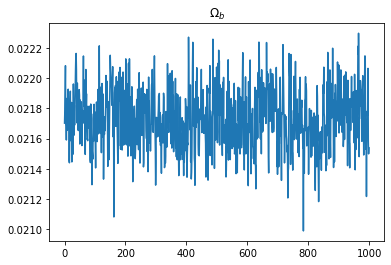

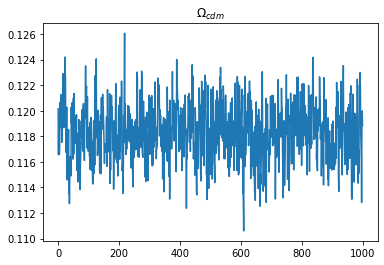

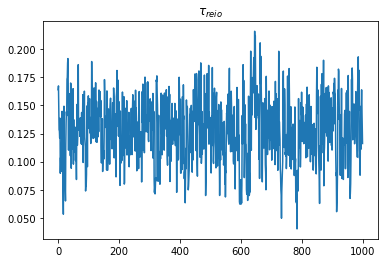

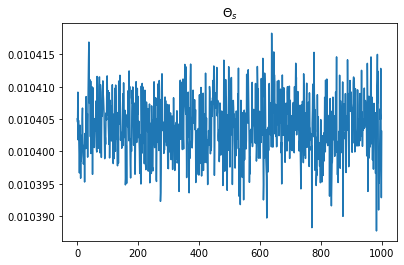

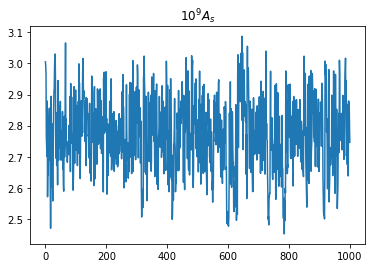

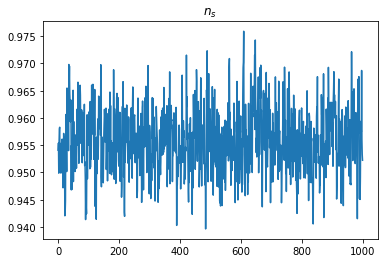

In [19]:
for i in range(6):
    plt.figure()
    plt.title(params[i])
    x = np.arange(dim)
    plt.plot(x,θChain[:,i])
    plt.show()

In [20]:
def Autocorrelation(x):
    dim = len(x)
    ρ   = np.zeros(dim,dtype=np.float64) 
    for i in range(dim):
        rtn = 0.
        for j in range(i+1,dim):
            if j > i:
                rtn += x[j] * x[j-i]
            else:
                rtn += x[j] * x[j-i+dim]
        ρ[i] = rtn / (dim-1)
    return ρ


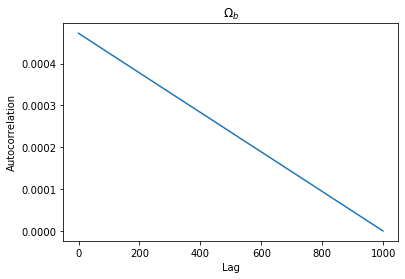

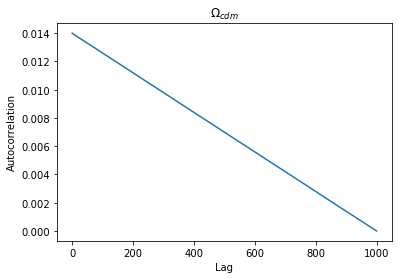

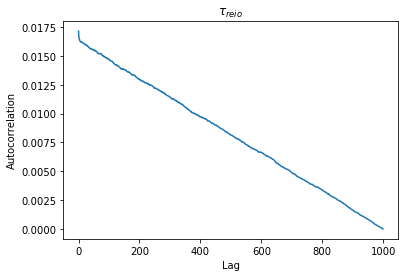

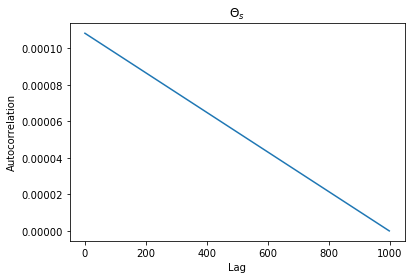

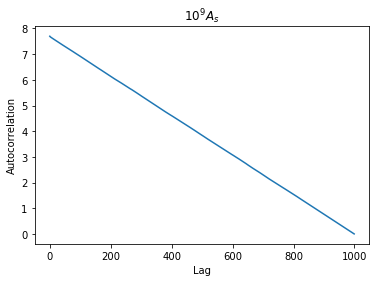

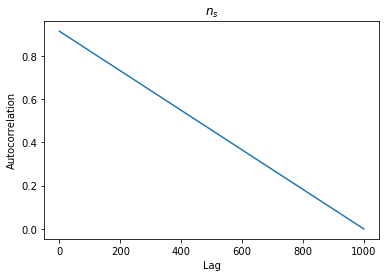

In [21]:
for i in range(6):
    plt.figure()
    plt.title(params[i])
    x = np.arange(dim)
    plt.plot(x, Autocorrelation(θChain[:,i]), label = params[i])
    plt.ylabel("Autocorrelation")
    plt.xlabel("Lag")    
    plt.show()



Removed no burn in


<Figure size 648x648 with 0 Axes>

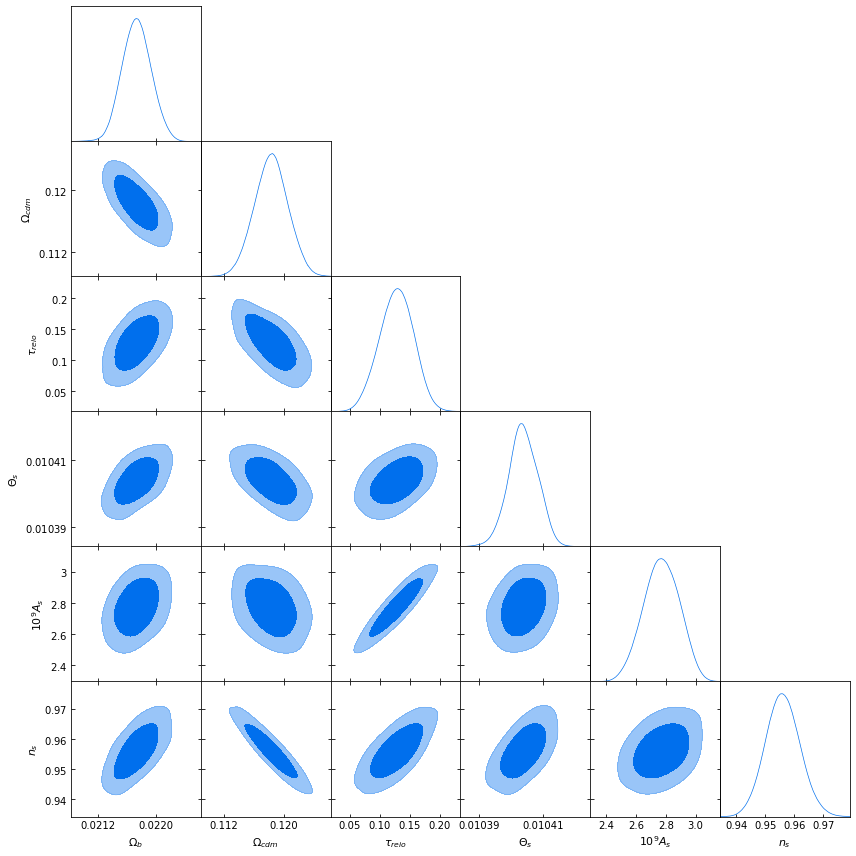

In [26]:
plt.figure(figsize=(9,9))
params_chain = [ r'$\Omega_b$', r'$\Omega_{cdm}$', r'$\tau_{reio}$', r'$\Theta_s$', r'$10^9A_s$', r'$n_s$']
full_chain    = θChain
samples = getdist.MCSamples(samples=full_chain, names=params_chain)
g = plots.getSubplotPlotter()
g.triangle_plot([samples], filled=True)

Define Walker and Affine-Invariant chain 

In [28]:
Nwalkers = 200
walkers = np.zeros((Nwalkers, 6), dtype=np.float64)
for i in range(Nwalkers):
    walkers[i,:] = optx + np.random.multivariate_normal(np.zeros(6), Σinv)



In [29]:
def AIchain(walkers, a, N, Nthin):
    Nwalkers = len(walkers[:,0])
    Ntot     = N*Nwalkers
    d        = len(walkers[0,:])
    θ        = np.zeros((Nwalkers+Ntot, d), dtype=np.float64)
    αhist    = np.zeros(Nwalkers+Ntot, dtype=np.float64)

    uhist    = np.zeros(Nwalkers+Ntot, dtype=np.float64)
    LogPostWalkers = np.zeros(Nwalkers, dtype=np.float64)
    θ0       = np.zeros(d, dtype=np.float64)
    θprop    = np.zeros(d, dtype=np.float64)

    k = 0
    
    print('start MCMC chain') 
    θ[:Nwalkers,:] = walkers.copy()
    for i in range(N):
        walkers  = θ[k:k+Nwalkers,:].copy()
        θ[Nwalkers+k:Nwalkers*2+k,:] = walkers.copy()
        
        for l in range(Nwalkers):
            θ0[:]             = walkers[l,:].copy()
            LogPostWalkers[l] = LogPost(θ0)

        
        for j in range(Nwalkers):
            z   = ((np.sqrt(a) - 1./np.sqrt(a)) * np.random.uniform() + 1./np.sqrt(a))**2     #  prop to 1/√z
            ind = int(np.random.uniform(Nwalkers-1))
            if j >= ind: 
                ind += 1
            
            θprop = (walkers[ind,:] + z * (walkers[j,:] - walkers[ind,:])).copy()
            
            u = np.log(np.random.uniform())
            LogPostProp = LogPost(θprop)
            α = np.min( [(d-1.)*np.log(z) + LogPostProp - LogPostWalkers[j], 0.])
            
            if u <= α:
                θ[Nwalkers+k,:] = θprop.copy()
                
            αhist[Nwalkers+k] = np.exp(α)
            uhist[Nwalkers+k] = np.exp(u)
            
            k += 1      
            
        P_accept = αhist[Nwalkers+k-1]
        print('accecptance rate is : {:.2f} ({:3d}/{:3d})'.format(P_accept, k, Ntot))

    print("MCMC chain is finished.")  
    ind = np.linspace(0, Ntot // Nthin * Nthin, Ntot // Nthin+1, dtype = np.int) + Nwalkers -1
    return αhist[ind], uhist[ind], θ[ind,:]


In [34]:
a = 2.
dim = 50
Nthin = 7
αhist, uhist, θChain2 = AIchain(walkers, a, dim, Nthin)

start MCMC chain
accecptance rate is : 0.29 (200/10000)
accecptance rate is : 0.44 (400/10000)
accecptance rate is : 1.00 (600/10000)
accecptance rate is : 0.13 (800/10000)
accecptance rate is : 0.34 (1000/10000)
accecptance rate is : 1.00 (1200/10000)
accecptance rate is : 0.98 (1400/10000)
accecptance rate is : 0.86 (1600/10000)
accecptance rate is : 0.35 (1800/10000)
accecptance rate is : 1.00 (2000/10000)
accecptance rate is : 0.01 (2200/10000)
accecptance rate is : 0.87 (2400/10000)
accecptance rate is : 0.07 (2600/10000)
accecptance rate is : 1.00 (2800/10000)
accecptance rate is : 1.00 (3000/10000)
accecptance rate is : 0.58 (3200/10000)
accecptance rate is : 0.93 (3400/10000)
accecptance rate is : 1.00 (3600/10000)
accecptance rate is : 0.95 (3800/10000)
accecptance rate is : 1.00 (4000/10000)
accecptance rate is : 0.11 (4200/10000)
accecptance rate is : 1.00 (4400/10000)
accecptance rate is : 0.00 (4600/10000)
accecptance rate is : 0.27 (4800/10000)
accecptance rate is : 0.93 

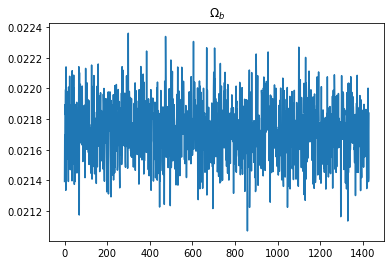

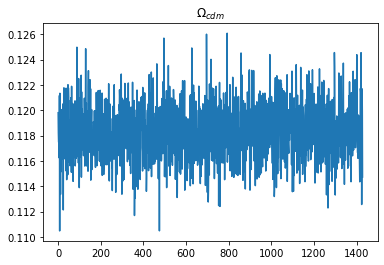

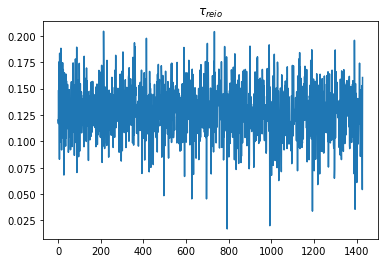

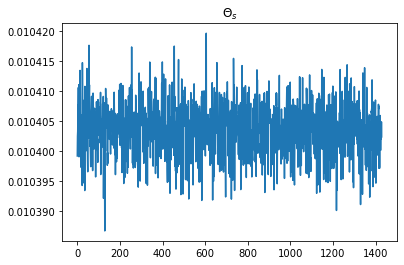

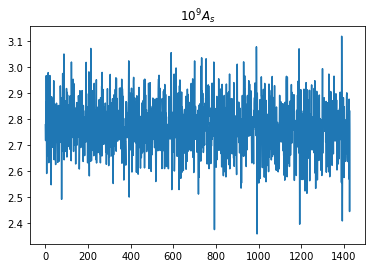

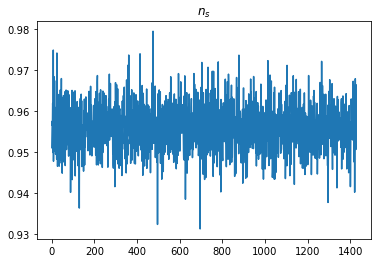

In [35]:
for i in range(6):
    plt.figure()
    plt.title(params[i])
    x = np.arange(len(θChain2[:,i]))
    plt.plot(x,θChain2[:,i])
    plt.show()

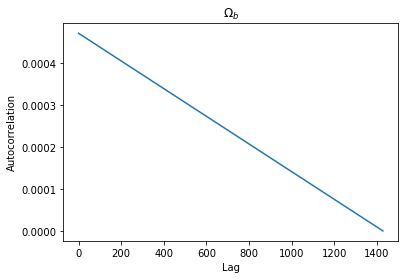

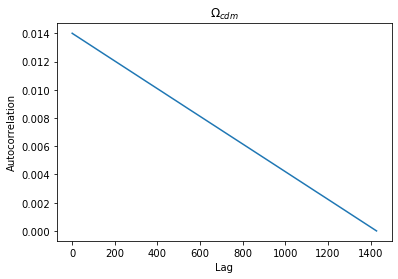

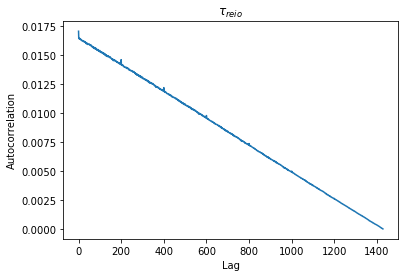

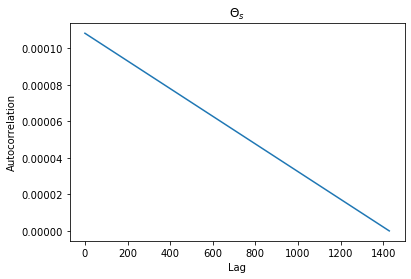

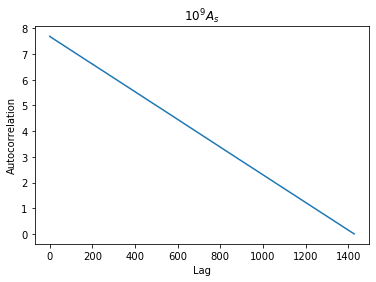

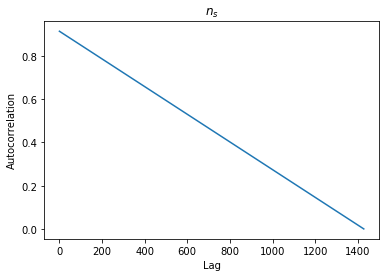

In [36]:
for i in range(6):
    plt.figure()
    plt.title(params[i])
    x = np.arange(len(θChain2[:,i]))
    plt.plot(x, Autocorrelation(θChain2[:,i]), label = params[i])
    plt.ylabel("Autocorrelation")
    plt.xlabel("Lag")    
    plt.show()


Removed no burn in


<Figure size 648x648 with 0 Axes>

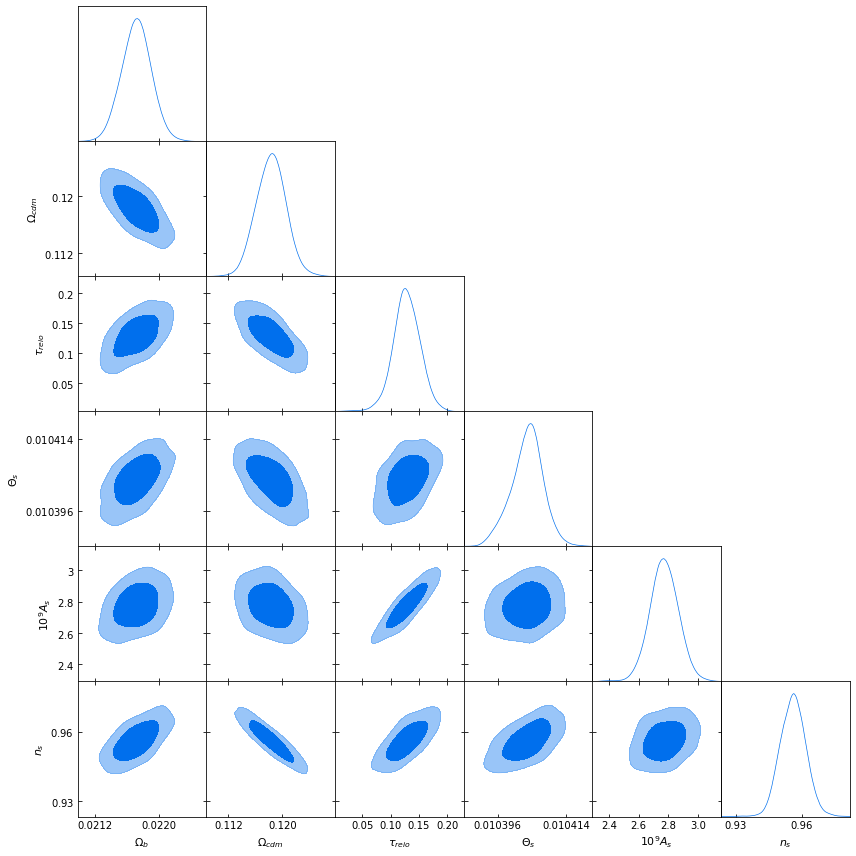

In [37]:
plt.figure(figsize=(9,9))
params_chain = [ r'$\Omega_b$', r'$\Omega_{cdm}$', r'$\tau_{reio}$', r'$\Theta_s$', r'$10^9A_s$', r'$n_s$']
full_chain    = θChain2
samples = getdist.MCSamples(samples=full_chain, names=params_chain)
g = plots.getSubplotPlotter()
g.triangle_plot([samples], filled=True)

Combine MCMC samples and WMAP Data

Removed no burn in
Removed no burn in
Removed no burn in


<Figure size 648x648 with 0 Axes>

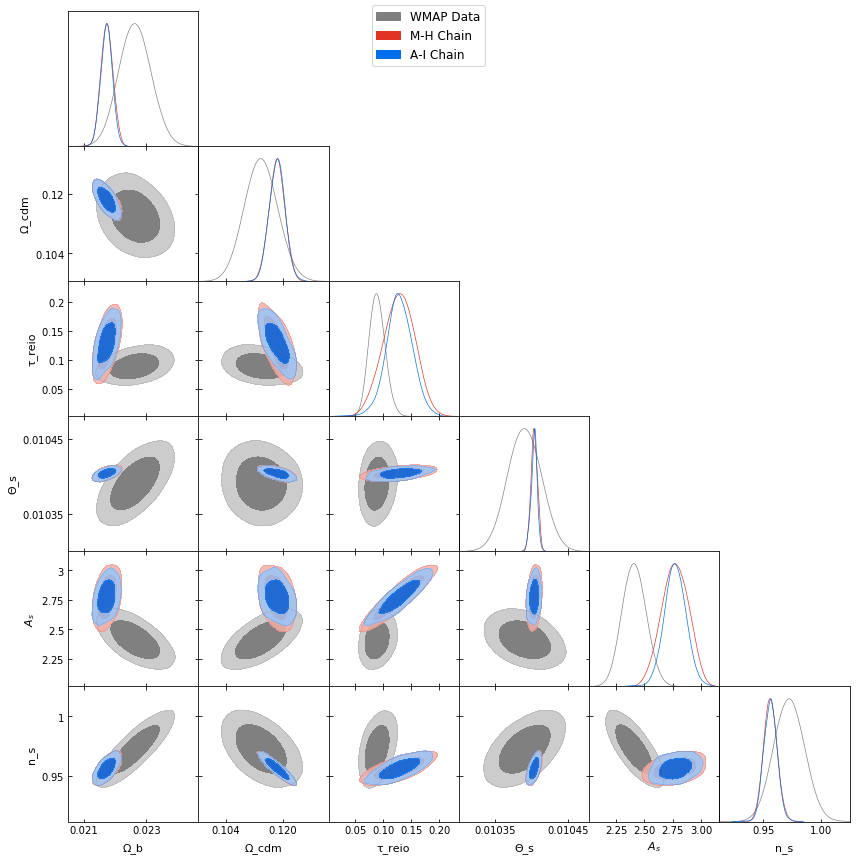

In [38]:
samples0 = getdist.MCSamples(samples=wmap_chain, names=names_chain)
samples1 = getdist.MCSamples(samples=θChain, names=names_chain)
samples2 = getdist.MCSamples(samples=θChain2, names=names_chain)
plt.figure(figsize=(9,9));
g = plots.getSubplotPlotter()
g.triangle_plot([samples0, samples1, samples2], filled=True, legend_labels = ["WMAP Data", "M-H Chain", "A-I Chain"])